# MNIST classification
----

Source: https://nextjournal.com/gkoehler/pytorch-mnist

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision as tv
import torch_tool as tt
import multiprocessing
from torch import nn
import torch.nn.functional as F
import os

dev = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch ver.{torch.__version__} running {dev}")

Torch ver.1.6.0a0+e088902 running cuda


## Create from scratch

In [2]:
class MNISTNet(nn.Module):
    
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

Use directly the BaseTrainer. No need to modify.

In [3]:
mnist = tt.BaseTrainer(log_dir=r"/mnt/data/train_camp/classify_mnist", model_name="SimpleFCN", device=dev)
mnist.model = MNISTNet()
mnist.optimizer = torch.optim.SGD(mnist.model.parameters(), lr=0.1, momentum=0.9)
mnist.loss = F.nll_loss

Set loaders if they haven't been created. Load if they exist.

In [4]:
if all([os.path.isfile(os.path.join(mnist.root_dir, f)) for f in ['train_loader.pth','val_loader.pth','test_loader.pth']]):
    # load
    mnist.load_loaders()
else:
    mnist.set_loader(
        dataset=tv.datasets.MNIST(root=r"/mnt/data/data", train=True, download=True, 
                                  transform=tv.transforms.Compose([
                                      tv.transforms.ToTensor()
                                  ])),
        batch_size=64,
        num_cpus=multiprocessing.cpu_count(),
        split=[0.7,0.2,0.1]
    )
    
    # save
    mnist.save_loaders()


Run the training

In [5]:
mnist.run(5)

  0%|          | 0/42000 [00:00<?, ?it/s]

BaseTrainer: reset the training, validation & test results.


Epoch 5: 100%|██████████| 42000/42000 [00:14<00:00, 2850.72it/s, loss=0.8428]


## Analyse

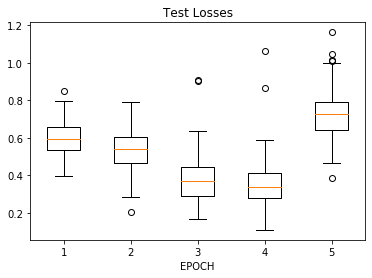

In [11]:
ax = plt.axes(xlabel='EPOCH')
ax.set_title('Test Losses')
bp = ax.boxplot(mnist.test_result['loss'].numpy())